# Ensable model

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## Prepare dataset directory

In [2]:
from pathlib import Path

DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Prepare & Visualise dataset

In [3]:
train_data = MNIST(root=DATA_DIR, train=True, download=True, transform=ToTensor())
test_data = MNIST(root=DATA_DIR, train=False, download=True, transform=ToTensor())

# take only small subset of training data to speed up the process
from torch.utils.data import Subset

TRAIN_SIZE = 5_000
train_data = Subset(train_data, range(TRAIN_SIZE))

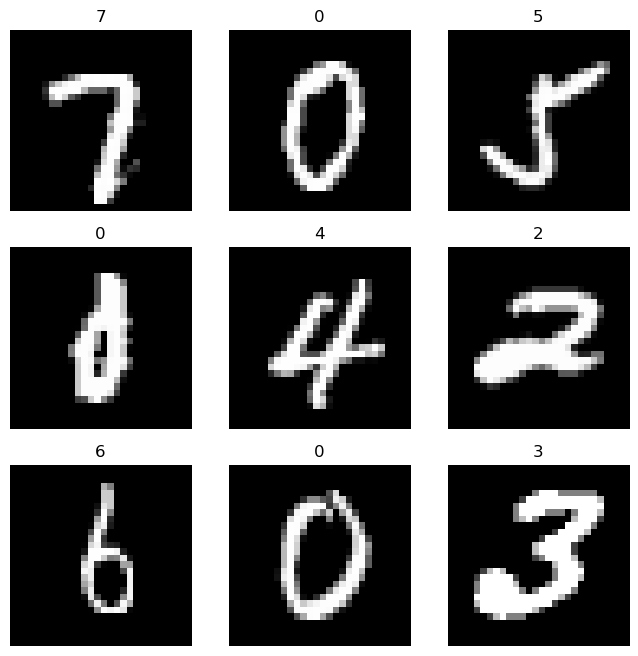

In [4]:
figure = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), "gray")

plt.show()

# Prepare DataLoader

In [5]:
batch_size = 64

from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

Features batch shape: torch.Size([64, 1, 28, 28])
Labeels batch shape: torch.Size([64])


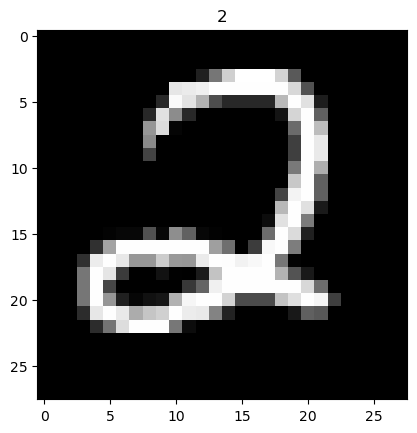

In [6]:
# DataLoader usage example
train_features, train_labels = next(iter(train_loader))
print(f"Features batch shape: {train_features.size()}")
print(f"Labeels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].item()
plt.imshow(img, "gray")
plt.title(label)
plt.show()

## Create device-agnostic code

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Create model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        return self.linear_relu_stack(x)

# Optimizing the model parameters

In [9]:
MODELS_NUM = 6
learning_rate = 3e-2

loss_fn = nn.CrossEntropyLoss()
models_list = [NeuralNetwork().to(device) for _ in range(MODELS_NUM)]
optimizers_list = [torch.optim.SGD(model.parameters(), lr=learning_rate) for model in models_list]

In [10]:
def train(data_loader, model, optimizer, loss_fn=loss_fn):
    dataset_size = len(data_loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 300:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"\tloss: {loss:>7f}  [{current:>5d}/{dataset_size:>5d}]")

In [ ]:
def test(data_loader, model, loss_fn):
    dataset_size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= dataset_size
        print(f"\tTest Error: \n\tAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

## Train models

In [ ]:
epochs = 10

models_loss_list = [list() for _ in range(MODELS_NUM)]

In [13]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    for i, (model, optimizer) in enumerate(zip(models_list, optimizers_list)):
        print(f"\tModel #{i+1}\n")
        train(train_loader, model, optimizer, loss_fn)
        models_loss_list[i].append(test(test_loader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
	Model #1

	loss: 2.296404  [  128/ 5000]
	loss: 2.299964  [  192/ 5000]
	loss: 2.298848  [  256/ 5000]
	loss: 2.299077  [  320/ 5000]
	loss: 2.293494  [  384/ 5000]
	loss: 2.297717  [  448/ 5000]
	loss: 2.293969  [  512/ 5000]
	loss: 2.296361  [  576/ 5000]
	loss: 2.291330  [  640/ 5000]
	loss: 2.286598  [  704/ 5000]
	loss: 2.290137  [  768/ 5000]
	loss: 2.287378  [  832/ 5000]
	loss: 2.288273  [  896/ 5000]
	loss: 2.280951  [  960/ 5000]
	loss: 2.283757  [ 1024/ 5000]
	loss: 2.282796  [ 1088/ 5000]
	loss: 2.283135  [ 1152/ 5000]
	loss: 2.281941  [ 1216/ 5000]
	loss: 2.281824  [ 1280/ 5000]
	loss: 2.276377  [ 1344/ 5000]
	loss: 2.262112  [ 1408/ 5000]
	loss: 2.273229  [ 1472/ 5000]
	loss: 2.271507  [ 1536/ 5000]
	loss: 2.262841  [ 1600/ 5000]
	loss: 2.262911  [ 1664/ 5000]
	loss: 2.267635  [ 1728/ 5000]
	loss: 2.263534  [ 1792/ 5000]
	loss: 2.262571  [ 1856/ 5000]
	loss: 2.252065  [ 1920/ 5000]
	loss: 2.257051  [ 1984/ 5000]
	loss: 2.251811  [ 

## Print loss for each model

In [136]:
def plot_models_loss(models_loss, *, zoomed_in=False, ensamble_loss=None):
    plt.figure(figsize=(14, 6) if zoomed_in else (7, 6))
    plt.subplot(1, 2, 1) if zoomed_in else plt.subplot(1, 1, 1)

    for i, model_loss in enumerate(models_loss):
        plt.plot(model_loss, label=f"Model {i}", marker="o", alpha=0.7)
    if ensamble_loss is not None:
        plt.plot(ensamble_loss, label=f"Ensamble", marker="o", c='r', linewidth=2.5)
    plt.title("Models loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(list(range(epochs)))
    plt.legend()

    if zoomed_in:
        plt.subplot(1, 2, 2)
        for i, model_loss in enumerate(models_loss):
            plt.plot(model_loss, label=f"Model {i}", marker="o", alpha=0.7)
        if ensamble_loss is not None:
            plt.plot(ensamble_loss, label=f"Ensamble", marker="o", c='r', linewidth=2.5)
        plt.title("Zoomed In Models loss")
        plt.xlim(3, 9.2)
        plt.ylim(0.35, 0.6)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

    plt.show()

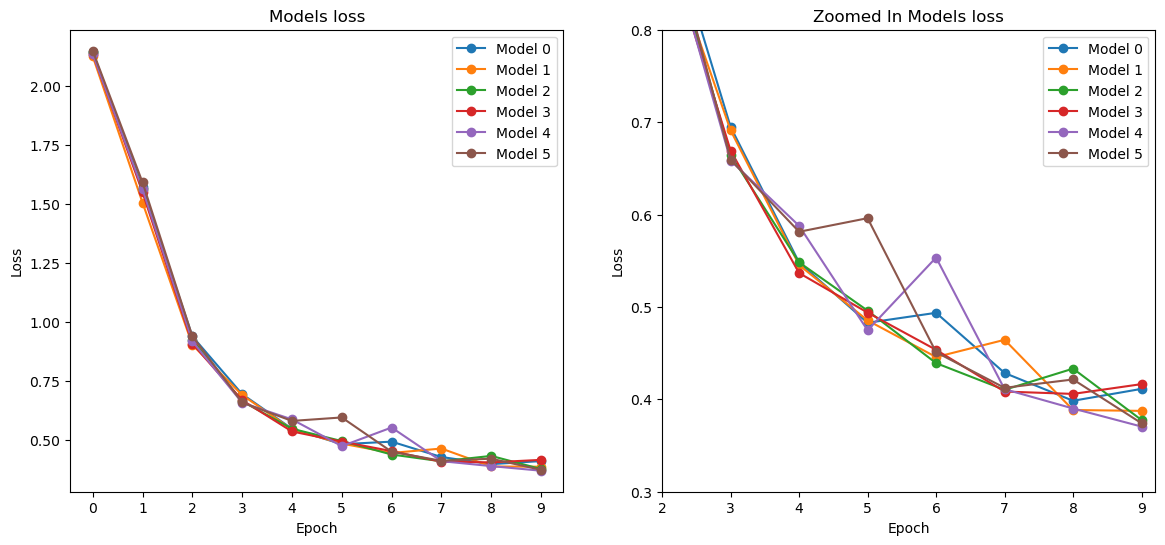

In [46]:
plot_models_loss(models_loss_list, True)

## Now let's focus on training models including EnsambleModel

In [100]:
class EnsambleModel(nn.Module):
    def __init__(self, model_list):
        super().__init__()
        self.model_list = model_list

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs = [model(x) for model in self.model_list]
        return torch.stack(outputs, dim=2).mean(dim=2)

In [101]:
MODELS_NUM = 6
learning_rate = 3e-2

loss_fn = nn.CrossEntropyLoss()
models_list = [NeuralNetwork().to(device) for _ in range(MODELS_NUM)]
ensamble_model = EnsambleModel(models_list)
optimizers_list = [torch.optim.SGD(model.parameters(), lr=learning_rate) for model in models_list]

In [102]:
epochs = 10

models_loss_list = [list() for _ in range(MODELS_NUM)]
ensamble_model_loss = list()

In [103]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    for i, (model, optimizer) in enumerate(zip(models_list, optimizers_list)):
        print(f"\tModel #{i+1}\n")
        train(train_loader, model, optimizer, loss_fn)
        models_loss_list[i].append(test(test_loader, model, loss_fn))
    print(f"\tModel #EnsambleModel\n")
    ensamble_model_loss.append(test(test_loader, ensamble_model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
	Model #1

	loss: 2.296824  [  128/ 5000]
	loss: 2.296773  [  192/ 5000]
	loss: 2.302687  [  256/ 5000]
	loss: 2.302673  [  320/ 5000]
	loss: 2.296619  [  384/ 5000]
	loss: 2.297153  [  448/ 5000]
	loss: 2.296653  [  512/ 5000]
	loss: 2.291478  [  576/ 5000]
	loss: 2.288051  [  640/ 5000]
	loss: 2.298198  [  704/ 5000]
	loss: 2.297187  [  768/ 5000]
	loss: 2.288046  [  832/ 5000]
	loss: 2.283211  [  896/ 5000]
	loss: 2.283504  [  960/ 5000]
	loss: 2.278863  [ 1024/ 5000]
	loss: 2.275667  [ 1088/ 5000]
	loss: 2.277352  [ 1152/ 5000]
	loss: 2.276359  [ 1216/ 5000]
	loss: 2.277735  [ 1280/ 5000]
	loss: 2.270931  [ 1344/ 5000]
	loss: 2.270915  [ 1408/ 5000]
	loss: 2.272629  [ 1472/ 5000]
	loss: 2.264879  [ 1536/ 5000]
	loss: 2.273324  [ 1600/ 5000]
	loss: 2.276024  [ 1664/ 5000]
	loss: 2.267852  [ 1728/ 5000]
	loss: 2.269476  [ 1792/ 5000]
	loss: 2.262381  [ 1856/ 5000]
	loss: 2.262020  [ 1920/ 5000]
	loss: 2.262020  [ 1984/ 5000]
	loss: 2.252300  [ 

## Visualize EnsambleModel learning process

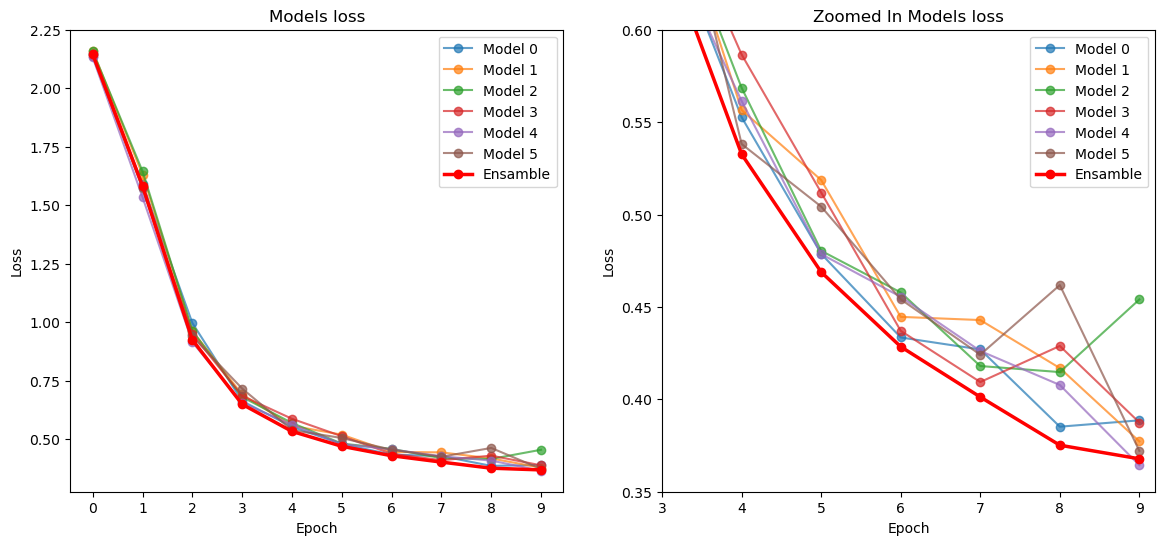

In [137]:
plot_models_loss(models_loss_list, zoomed_in=True, ensamble_loss=ensamble_model_loss)